In [117]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn import ensemble
from sklearn.preprocessing import normalize
import math

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train.sample(5)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
4315,4316,2073,67,17,0,0,451,234,204,96,...,0,0,0,0,0,0,0,0,0,4
10587,10588,2995,155,30,134,58,3376,239,226,93,...,0,0,0,0,0,0,0,0,0,2
11404,11405,3004,235,6,216,9,5698,210,245,173,...,0,0,0,0,0,0,0,0,0,1
3802,3803,2178,131,26,108,53,1158,251,216,76,...,0,0,0,0,0,0,0,0,0,4
2997,2998,2389,83,22,268,27,992,244,196,70,...,0,0,0,0,0,0,0,0,0,3


In [7]:
df_train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [ ]:
# remove: ['Id', 'Cover_Type']
# normalize: ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points', 'Elevation']
# log: Horizontal_Distance_To_Roadways
# soil_12_32:
# soil_22_23_32_33:

Aspect


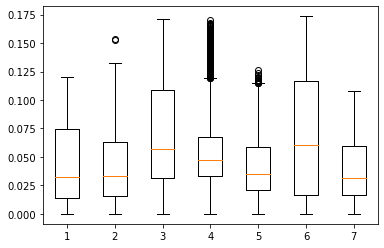

Slope


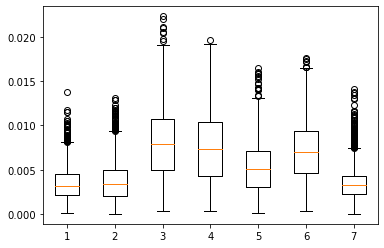

Horizontal_Distance_To_Hydrology


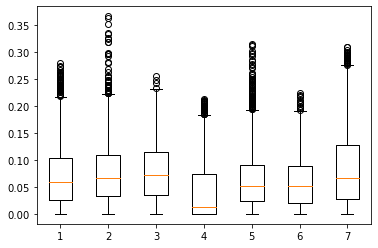

Vertical_Distance_To_Hydrology


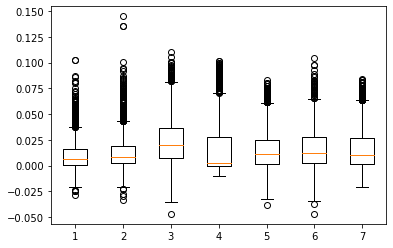

Hillshade_9am


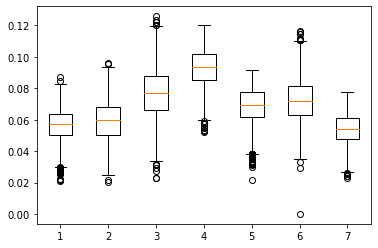

Hillshade_Noon


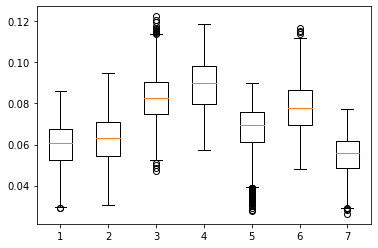

Hillshade_3pm


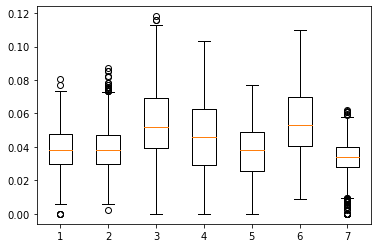

Horizontal_Distance_To_Fire_Points


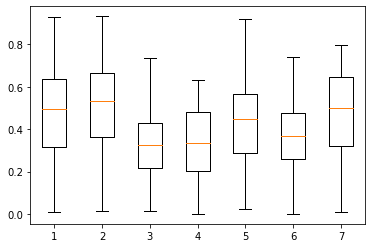

Elevation


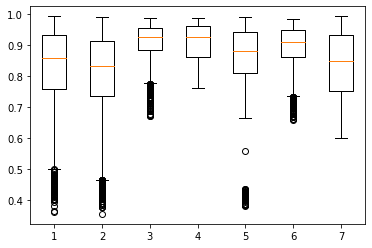

In [46]:
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points', 'Elevation']
df_train[col_normalize] = normalize(df_train[col_normalize])
for col in col_normalize:
    print(col)
    l = []
    for cover in sorted(df_train.Cover_Type.unique()):
        l.append( [v for v,k in zip(df_train[col],df_train['Cover_Type']) if k==cover]
                )
    plt.boxplot(l)
    plt.show()

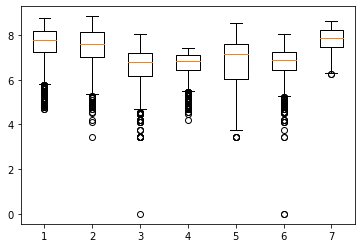

In [48]:
l = []
for cover in sorted(df_train.Cover_Type.unique()):
    l.append( [math.log(v+1) for v,k in zip(df_train['Horizontal_Distance_To_Roadways'],df_train['Cover_Type']) if k==cover]
            )
plt.boxplot(l)
plt.show()

k=1:	0.915721143802401
k=2:	0.9999997399231917
k=3:	0.999999928991774
k=4:	0.999999944133614
k=5:	0.9999999556039334
k=10:	0.9999999718258159
k=20:	0.9999999904046641
k=30:	0.9999999981996377
k=40:	0.9999999997898495
k=50:	0.9999999999997117


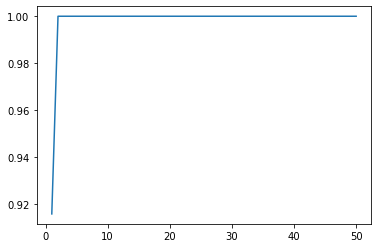

In [49]:
results = []
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    pca = PCA(n_components=k)
    pca.fit(df_train.to_numpy(), df_train['Cover_Type'].to_numpy())
    explained_variance = pca.explained_variance_ratio_.sum()
    print("k={}:\t{}".format(k,explained_variance))
    results.append([k, explained_variance])
plt.plot(np.array(results)[:,0], np.array(results)[:,1])

In [52]:
soils = [x for x in df_train.columns if "Soil" in x]

In [79]:
from itertools import combinations 

In [84]:
for x in combinations(soils, 3):
    print(x)
    break

('Soil_Type1', 'Soil_Type2', 'Soil_Type3')
<class 'tuple'>


In [121]:
df_train[soils].sum(axis=1).value_counts()

1    15120
dtype: int64

In [103]:
from tqdm.notebook import tqdm

classes = []
for n in tqdm(range(2,6)):
    for x in tqdm(combinations(soils, n)):
        pca = PCA(n_components=1)
        pca.fit(df_train[list(x)].to_numpy(), df_train['Cover_Type'].to_numpy())
        explained_variance = pca.explained_variance_ratio_.sum()
        classes.append([*x] + [" "]*(5-n) + [explained_variance])

r = pd.DataFrame(classes, columns=['S1','S2','S3','S4','S5','var'])
r['var'] -= 1
r[r['var']>=0].sort_values('var',ascending=False)

r.sort_values('var',ascending=False).to_csv('PCA results.csv', index=False)

k=1:	0.8883310714788775
k=2:	0.9999996245282774
k=3:	0.9999999212347399
k=4:	0.9999999385698952
k=5:	0.9999999500513905
k=10:	0.999999969850004
k=20:	0.999999989109917
k=30:	0.9999999978679196
k=40:	0.9999999997703708
k=50:	0.9999999999968857


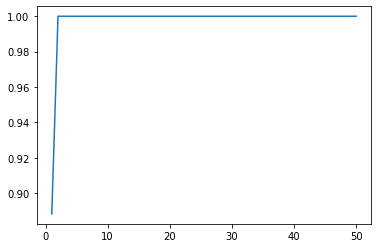

In [118]:
results = []
for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]:
    pca = TruncatedSVD(n_components=k)
    pca.fit(df_train.to_numpy(), df_train['Cover_Type'].to_numpy())
    explained_variance = pca.explained_variance_ratio_.sum()
    print("k={}:\t{}".format(k,explained_variance))
    results.append([k, explained_variance])
plt.plot(np.array(results)[:,0], np.array(results)[:,1])

In [1]:
# class 1-2
# class 1-2-5

In [2]:
# class 3-6
# class 3-4
# class 3-4-6